In [1]:
import time
import numpy as np
import autograd.numpy as np1
from scipy.optimize import Bounds
import torch
from torch import Tensor, optim
import torch.optim.lr_scheduler as lr_scheduler
from naliu import TestODEF
from neural_ode import NeuralODE
from utils import circle_points, plot_trajectories

In [2]:
from tqdm import tqdm
from hypernet import Hypernet_trans
from nnode import NNODEF
import math

# Define

In [3]:
class Problem():
    def __init__(self, f, dim_x, dim_y, proj_C, proj_Qplus):
        self.f = f
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.proj_C = proj_C
        self.proj_Qplus = proj_Qplus
    
    def objective_func(self, x):
        vals = [func(x) for func in self.f]
        return np.concatenate(vals)  

In [4]:
def f1(x):
    return 4*x[0]**2 + 4*x[1]**2

def f2(x):
    return (x[0] - 5)**2 + (x[1] - 5)**2

prob = Problem(
    f=[f1, f2],
    dim_x=None, dim_y=None,
    proj_C=None,
    proj_Qplus=None
)

In [12]:
import yaml
config_path='../4_Pareto_front/config.yaml'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
test_rays = np.array(cfg['data']['test_ray'])
z_star = np.array([75.23575795, 25.50204271])

In [13]:
class TorchProblem:
    """
    Phiên bản PyTorch của bài toán để dùng trong Loss Function
    """
    @staticmethod
    def get_f_values(x):
        """
        Input x: Tensor shape (1, 2)
        Output: Tensor shape (1, 2) gồm [f1, f2]
        """
        # f1 = 4*x1^2 + 4*x2^2
        f1 = 4 * x[:, 0]**2 + 4 * x[:, 1]**2
        
        # f2 = (x1 - 5)^2 + (x2 - 5)^2
        f2 = (x[:, 0] - 5)**2 + (x[:, 1] - 5)**2
        
        return torch.stack([f1, f2], dim=1)

    @staticmethod
    def get_c_violation(x):
        """
        Tính mức độ vi phạm ràng buộc C (Penalty).
        Trả về 0 nếu thỏa mãn, > 0 nếu vi phạm.
        """
        # c1: -(x1 - 5)^2 - x2^2 + 25 >= 0
        val_c1 = -(x[:, 0] - 5)**2 - x[:, 1]**2 + 25
        # Vi phạm nếu val_c1 < 0 -> Penalty = ReLU(-val_c1)
        viol_c1 = torch.relu(-val_c1)

        # c2: -(x1 - 8)^2 - (x2 + 3)^2 + 17.7 >= 0
        val_c2 = -(x[:, 0] - 8)**2 - (x[:, 1] + 3)**2 + 17.7
        viol_c2 = torch.relu(-val_c2)
        
        # Có thể thêm Bounds [-15, 30] nếu cần, nhưng c1/c2 thường chặt hơn
        return viol_c1**2 + viol_c2**2

# ==========================================
# 2. HÀM SINH VECTOR R NGẪU NHIÊN
# ==========================================
def sample_one_ray(device='cpu'):
    """
    Sinh ngẫu nhiên 1 vector r trong góc phần tư thứ nhất.
    Góc theta từ 0 đến 90 độ.
    Input hypernet yêu cầu shape (1, 2)
    """
    theta = torch.rand(1) * (np.pi / 2) # Uniform [0, pi/2]
    r1 = torch.cos(theta)
    r2 = torch.sin(theta)
    r = torch.stack([r1, r2], dim=1).to(device)
    return r

In [25]:
def train_hypernet_non_constraint(hypernet, z_star, n_iters=5000, lr=1e-3, device='cpu'):
    """
    Huấn luyện Hypernet chỉ để tối ưu hàm Chebyshev, bỏ qua C và Q+.
    Mục tiêu: Học 'bản đồ' hàm mục tiêu F.
    """
    optimizer = optim.Adam(hypernet.parameters(), lr=lr)
    hypernet.to(device)
    hypernet.train()
    
    # Chuyển z_star sang tensor
    z_star_t = torch.tensor(z_star, dtype=torch.float32).to(device).unsqueeze(0) # Shape (1, 2)

    print("--- Training Non-Constraint Hypernet ---")
    for i in range(n_iters):
        optimizer.zero_grad()
        
        # 1. Sinh ngẫu nhiên 1 vector r
        r = sample_one_ray(device)
        
        # 2. Forward: Hypernet dự đoán x
        # Model nhận input (N, 2) nhưng output bị mean về (1, 2)
        x_pred = hypernet(r) 
        
        # 3. Tính giá trị f1, f2
        f_vals = TorchProblem.get_f_values(x_pred)
        
        # 4. Tính Chebyshev Loss
        # Loss = max(r * (f(x) - z*))
        # weighted_diff shape (1, 2)
        weighted_diff = r * (f_vals - z_star_t)
        
        # Lấy max theo chiều features (dim=1)
        chebyshev_obj, _ = torch.max(weighted_diff, dim=1)
        
        loss = chebyshev_obj.mean() # Mean thực ra là chính nó vì batch=1
        
        # 5. Backward
        loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            print(f"Iter {i+1}/{n_iters} | Loss: {loss.item():.4f}")

    return hypernet

# ==========================================
# 4. HUẤN LUYỆN CÓ RÀNG BUỘC (With Constraints Penalty)
# ==========================================
def train_hypernet(hypernet, z_star, n_iters=5000, lr=1e-3, lambda_c=100.0, device='cpu'):
    """
    Huấn luyện Hypernet với hàm Loss tổng hợp:
    Loss = Chebyshev_Obj + lambda * Constraint_Penalty
    (Không dùng Anchor, chỉ dùng Penalty để ép buộc x vào C)
    """
    optimizer = optim.Adam(hypernet.parameters(), lr=lr)
    hypernet.to(device)
    hypernet.train()
    
    z_star_t = torch.tensor(z_star, dtype=torch.float32).to(device).unsqueeze(0)

    print("--- Training Constrained Hypernet ---")
    for i in range(n_iters):
        optimizer.zero_grad()
        
        # 1. Sinh input
        r = sample_one_ray(device)
        
        # 2. Forward
        x_pred = hypernet(r)
        
        # 3. Tính Objective Loss
        f_vals = TorchProblem.get_f_values(x_pred)
        weighted_diff = r * (f_vals - z_star_t)
        obj_loss, _ = torch.max(weighted_diff, dim=1)
        
        # 4. Tính Constraint Loss (Penalty Method)
        # Chỉ xét tập C (Input Constraints) vì nó quan trọng nhất để x có nghĩa
        # Tập Q+ thường được thỏa mãn tự nhiên khi tối ưu hóa (vì ta minimize f)
        viol_c = TorchProblem.get_c_violation(x_pred)
        constraint_loss = torch.sum(viol_c)
        
        # 5. Tổng hợp Loss
        total_loss = obj_loss + lambda_c * constraint_loss
        
        # 6. Backward
        total_loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            print(f"Iter {i+1}/{n_iters} | Obj: {obj_loss.item():.3f} | Cons: {constraint_loss.item():.4f}")

    return hypernet

In [26]:
hypernet = Hypernet_trans(ray_hidden_dim=16, out_dim=2, n_tasks=2) 
train_hypernet_non_constraint(hypernet, z_star, n_iters=20000, lr=1e-3, device='cpu')

--- Training Non-Constraint Hypernet ---
Iter 500/20000 | Loss: -0.7619
Iter 1000/20000 | Loss: -6.0880
Iter 1500/20000 | Loss: -6.3997
Iter 2000/20000 | Loss: -11.4411
Iter 2500/20000 | Loss: -9.5060
Iter 3000/20000 | Loss: -6.2311
Iter 3500/20000 | Loss: -10.4598
Iter 4000/20000 | Loss: -10.4911
Iter 4500/20000 | Loss: -10.5714
Iter 5000/20000 | Loss: -11.4346
Iter 5500/20000 | Loss: -9.2480
Iter 6000/20000 | Loss: -5.7772
Iter 6500/20000 | Loss: -11.0804
Iter 7000/20000 | Loss: -7.6587
Iter 7500/20000 | Loss: -10.1157
Iter 8000/20000 | Loss: -7.7964
Iter 8500/20000 | Loss: -4.0337
Iter 9000/20000 | Loss: -4.8878
Iter 9500/20000 | Loss: -10.2725
Iter 10000/20000 | Loss: -7.9578
Iter 10500/20000 | Loss: -11.4159
Iter 11000/20000 | Loss: -11.4261
Iter 11500/20000 | Loss: -10.9479
Iter 12000/20000 | Loss: -4.5631
Iter 12500/20000 | Loss: -0.4886
Iter 13000/20000 | Loss: -9.6230
Iter 13500/20000 | Loss: -8.8717
Iter 14000/20000 | Loss: -9.1387
Iter 14500/20000 | Loss: -10.9343
Iter 15000

Hypernet_trans(
  (embedding_layer1): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU(inplace=True)
  )
  (embedding_layer2): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU(inplace=True)
  )
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
  )
  (ffn1): Linear(in_features=16, out_features=16, bias=True)
  (ffn2): Linear(in_features=16, out_features=16, bias=True)
)

In [21]:
hypernet = Hypernet_trans(ray_hidden_dim=16, out_dim=2, n_tasks=2) 
train_hypernet(hypernet, z_star, n_iters=20000, lr=1e-3, lambda_c=100.0, device='cpu')

--- Training Constrained Hypernet ---
Iter 500/20000 | Obj: 35.570 | Cons: 0.0000
Iter 1000/20000 | Obj: 30.516 | Cons: 0.0000
Iter 1500/20000 | Obj: 27.745 | Cons: 0.0000
Iter 2000/20000 | Obj: 24.573 | Cons: 0.0000
Iter 2500/20000 | Obj: 13.035 | Cons: 0.0000
Iter 3000/20000 | Obj: 21.704 | Cons: 0.0000
Iter 3500/20000 | Obj: 13.255 | Cons: 0.0000
Iter 4000/20000 | Obj: 15.786 | Cons: 0.0000
Iter 4500/20000 | Obj: 5.485 | Cons: 0.0000
Iter 5000/20000 | Obj: 6.172 | Cons: 0.0000
Iter 5500/20000 | Obj: 9.135 | Cons: 0.0000
Iter 6000/20000 | Obj: 4.432 | Cons: 0.0121
Iter 6500/20000 | Obj: 5.672 | Cons: 0.0000
Iter 7000/20000 | Obj: 5.570 | Cons: 0.0000
Iter 7500/20000 | Obj: 8.554 | Cons: 0.0000
Iter 8000/20000 | Obj: 6.862 | Cons: 0.1230
Iter 8500/20000 | Obj: 7.430 | Cons: 0.0000
Iter 9000/20000 | Obj: 7.859 | Cons: 0.0000
Iter 9500/20000 | Obj: 6.204 | Cons: 0.0000
Iter 10000/20000 | Obj: 5.918 | Cons: 0.0000
Iter 10500/20000 | Obj: 8.806 | Cons: 0.0000
Iter 11000/20000 | Obj: 6.694

Hypernet_trans(
  (embedding_layer1): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU(inplace=True)
  )
  (embedding_layer2): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU(inplace=True)
  )
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
  )
  (ffn1): Linear(in_features=16, out_features=16, bias=True)
  (ffn2): Linear(in_features=16, out_features=16, bias=True)
)

# Test

In [27]:
pf_true = np.load("../4_Pareto_front/tmp/pf_true.npy")
target_space = np.load("../4_Pareto_front/tmp/target_space.npy")

## Hypernet

In [28]:
hypernet.eval()

pf_pred = [] 
tmp_err = [] 

t1 = time.time()


print(f"Evaluating on {len(test_rays)} rays...")

for r in test_rays:

    
    # --- Dự đoán với Hypernetwork ---
    ray_t = torch.from_numpy(r).float().unsqueeze(0)
    
    with torch.no_grad(): 
        output_x = hypernet(ray_t).squeeze()

        vals = [func(output_x).item() for func in prob.f]
        
        obj_pred = np.array(vals)
    
    pf_pred.append(obj_pred)
    
#     err = np.sum(np.abs(obj_pred - y_test))
#     tmp_err.append(err)
    

t2 = time.time()

pf_pred = np.array(pf_pred)

print("-" * 30)
# print(f"Mean L1 Error: {np.mean(tmp_err):.6f}")
print(f"Inference Time: {t2-t1:.4f}s")

Evaluating on 25 rays...
------------------------------
Inference Time: 0.0103s


<Figure size 1600x800 with 0 Axes>

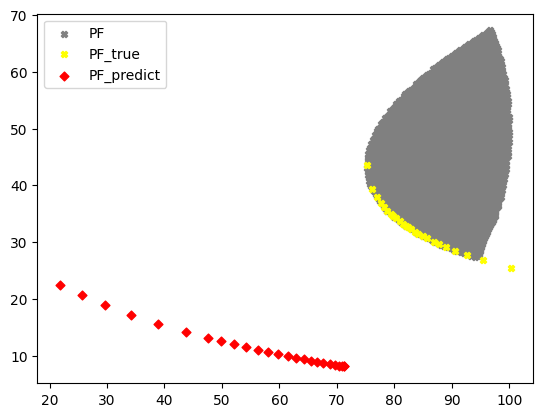

In [29]:
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred),obs_pareto_front=target_space , figsize=(16, 8))